In [1]:
import pandas as pd
import numpy as np
from scipy import stats


random_state = np.random.RandomState(2925)
np.random.seed(2925) # for reproducibility"

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import  LabelEncoder

from keras.regularizers import l2,l1
from keras.layers import Input, Embedding, Dense, Dropout, Flatten
from keras.models import Model
from keras.layers.core import Lambda
from keras import backend as K
from keras import layers
from keras import optimizers
from keras.layers.advanced_activations import PReLU


Using TensorFlow backend.


In [2]:
def make_country_df(preds, test_feat, country):
    # make sure we code the country correctly
    country_codes = ['A', 'B', 'C']
    
    # get just the poor probabilities
    country_sub = pd.DataFrame(data=preds,  # proba p=1
                               columns=['poor'], 
                               index=test_feat.index)

    
    # add the country code for joining later
    country_sub["country"] = country
    return country_sub[["country", "poor"]]

# Models

In [3]:
def expand_dims(x):
    return K.expand_dims(x, 1)

def expand_dims_output_shape(input_shape):
    return (input_shape[0], 1, input_shape[1])

In [4]:
# Standardize features
def standardize(df, numeric_only=True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    # subtracy mean and divide by std
    df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()
    return df


def keras_encoding(df_train,df_test):

    ntrain = df_train.shape[0]
    df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
    
    num_list = list(df_train.select_dtypes(include=['int64', 'float64']).columns)
    df_all = standardize(df_all)
    
    cat_list = list(df_train.select_dtypes(include=['object', 'bool']).columns)
    for c in cat_list:
        df_all[c] = df_all[c].astype('category').cat.as_ordered()
        
    le = LabelEncoder()

    for col in cat_list:
        le.fit(df_all[col].values)
        df_all[col] = le.transform(df_all[col].values)

    Din = dict()
    Dout = dict()   
    for col in cat_list:
        cat_sz = np.size(np.unique(df_all[col].values))
        Din[col]= cat_sz
        Dout[col] = max(3,min(50, (cat_sz+1)//2))
    
    df_train = df_all.iloc[:ntrain,:].copy()
    df_test = df_all.iloc[ntrain:,:].copy()
    return df_train, df_test, num_list, cat_list, Din, Dout

In [5]:
def batch_generator(X, y,cat_list,num_list,batch_size):
    
    n_splits = X.shape[0] // (batch_size - 1)

    skf = StratifiedKFold(n_splits=n_splits,random_state=2925, shuffle=True)

    while True:
        for idx_tr, idx_te in skf.split(X, y):
            X_batch = X.iloc[idx_te].reset_index(drop=True).copy()
            y_batch = y[idx_te]
        
            X_list = []
            for col in cat_list:
                X_list.append(X_batch[col].values)
            X_list.append(X_batch[num_list].values)
            X_batch = X_list    

            yield (X_batch, y_batch)

            
            
def Keras_B01(Xtr,Ytr,Xte,num_list, cat_list, Din, Dout,cv_i):

    X_list = []
    for col in cat_list:
        X_list.append(Xte[col].values)
    X_list.append(Xte[num_list].values)
    X_test = X_list

    l2_emb = 0.00001

    #emb_layers=[]
    cat_out = []
    cat_in = []

    #cat var
    for idx, var_name in enumerate(cat_list):
        x_in = Input(shape=(1,), dtype='int64', name=var_name+'_in')

        input_dim = Din[var_name]
        output_dim = Dout[var_name]
        x_out = Embedding(input_dim, 
                          output_dim, 
                          input_length=1, 
                          name = var_name, 
                          embeddings_regularizer=l1(l2_emb))(x_in)

        flatten_c = Flatten()(x_out)
        #emb_layers.append(x_out) 
        
        cat_in.append(x_in)
        cat_out.append(flatten_c)  
        
    x_emb = layers.concatenate(cat_out,name = 'emb')

    #continuous variables
    cont_in = Input(shape=(len(num_list),), name='continuous_input')
    cont_out = Lambda(expand_dims, expand_dims_output_shape)(cont_in)
    x_num = Flatten(name = 'num')(cont_out)

    cat_in.append(cont_in)

    #merge
    x = layers.concatenate([x_emb,x_num],name = 'emb_num')
    x = Dense(512 ,activation='relu')(x)
    x = PReLU()(x)
    x = Dropout(0.6)(x)
    x = Dense(64)(x)
    x = PReLU()(x)
    x = Dropout(0.3)(x)
    x = Dense(32)(x)
    x = PReLU()(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = cat_in, outputs = x)

    model.compile(optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    batch_size = 256
    model.fit_generator(generator=batch_generator(Xtr, Ytr,cat_list,num_list, batch_size),
                    epochs=10, verbose=0, steps_per_epoch= np.floor(Xtr.shape[0]/batch_size))

    Yt = model.predict(X_test).flatten()
    K.clear_session()
    return Yt

# Data Processing

In [6]:
def pre_process_data(df, enforce_cols=None):
    #print("Input shape:\t{}".format(df.shape))
    df.drop(["country"], axis=1, inplace=True)

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)

        df.drop(to_drop, axis=1, inplace=True)
        df = df.assign(**{c: 0 for c in to_add})
    
    df.fillna(df.mean(), inplace=True)
    
    return df

In [7]:
data_paths = {'A': {'train_hhold': 'data/A_hhold_train.csv', 
                        'test_hhold':  'data/A_hhold_test.csv',
                        'train_indiv': 'data/A_indiv_train.csv', 
                        'test_indiv':  'data/A_indiv_test.csv'}, 

                  'B': {'train_hhold': 'data/B_hhold_train.csv', 
                        'test_hhold':  'data/B_hhold_test.csv',
                        'train_indiv': 'data/B_indiv_train.csv', 
                        'test_indiv':  'data/B_indiv_test.csv'}, 

                  'C': {'train_hhold': 'data/C_hhold_train.csv', 
                        'test_hhold':  'data/C_hhold_test.csv',
                        'train_indiv': 'data/C_indiv_train.csv', 
                        'test_indiv':  'data/C_indiv_test.csv'}}

In [8]:
def get_hhold_size(data_indiv):
    return data_indiv.groupby('id').country.agg({'hhold_size':'count'})

In [9]:
def get_features(Country='A', f_dict=None, traintest='train'):
      
    # load data
    data_hhold = pd.read_csv(data_paths[Country]['%s_hhold' % traintest], index_col='id')
    data_indiv = pd.read_csv(data_paths[Country]['%s_indiv' % traintest], index_col='id')

    ## Add indiv features:
    #hhold size
    if f_dict.get('hh_size'):
        data_hh_size = get_hhold_size(data_indiv)
        data_hhold = data_hhold.merge(data_hh_size, left_index=True, right_index=True)

    
    return data_hhold

In [10]:
def read_test_train_v2():

    feat = dict()
    feat['B'] = dict()
    feat['B']['hh_size'] = True

    b_train = get_features(Country='B', f_dict=feat['B'], traintest='train')  
    b_test = get_features(Country='B', f_dict=feat['B'], traintest='test')  
    
    print("\nCountry B")
    bX_train = pre_process_data(b_train.drop('poor', axis=1))
    by_train = np.ravel(b_train.poor)


    # process the test data
    bX_test = pre_process_data(b_test, enforce_cols=bX_train.columns)
    
    bremove_list = ['IrxBnWxE']    
    
    bX_train.drop(bremove_list, axis=1, inplace=True)
    bX_test.drop(bremove_list, axis=1, inplace=True)
    
    print("--------------------------------------------")
    return bX_train, by_train, bX_test

In [11]:
bX_train, bY_train, bX_test = read_test_train_v2()

/home/texugo/anaconda3/envs/ag100/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  



Country B
--------------------------------------------


# Model Train/Predict

## Def

In [12]:
model = {'A':'Keras_A01','B':'Keras_B01','C':'Keras_C01'}

datafiles = {}
datafiles['out'] = 'predictions/Keras_M03_F08_'

## Submission

In [13]:
bX_train, bX_test, bnum_list, bcat_list, bDin, bDout = keras_encoding(bX_train,bX_test)

In [14]:
b_preds = eval(model['B'])(bX_train, bY_train, bX_test,bnum_list, bcat_list, bDin, bDout,0)

In [15]:
# convert preds to data frames
b_sub = make_country_df(b_preds.flatten(), bX_test, 'B')

In [16]:
b_sub.to_csv(datafiles['out']+'_B_test.csv')

In [17]:
df1 = pd.read_csv('./predictions/Keras_M03_F08__B_test.csv')
df2 = pd.read_csv('./predictions/Keras_M03_F08__B_test_clean.csv')

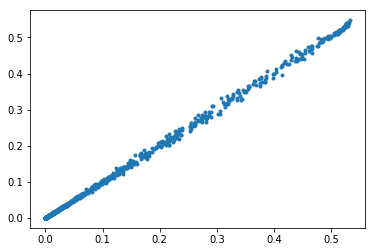

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(df1.poor, df2.poor, '.')